# Google Colab Set up to Load Dataset

Run this if working in a Google Colab

In [1]:
!git clone https://github.com/jasonjabbour/Diffusion_Planning.git

fatal: destination path 'Diffusion_Planning' already exists and is not an empty directory.


In [1]:
%cd Diffusion_Planning

/home/jason/Desktop/Jason/Diffusion/Diffusion_Planning


In [2]:
!ls

Captures  Checkpoints  Modeling  PathPlanning  README.md  requirements.txt


# Load Dependencies

In [3]:
import torch
import pandas as pd
import numpy as np
import json
import os
import math
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision import transforms
from torchinfo import summary

# Data Preparation

In [4]:
class PathPlanningDataset(Dataset):
    def __init__(self, csv_file, map_dir, transform=None, normalize_path_live=False):
        self.path_data = pd.read_csv(csv_file)
        self.map_dir = map_dir
        self.transform = transform
        self.pair_ids = self.path_data['pair_id'].unique()
        self.max_path_length = self.find_max_path_length()
        self.normalize_path_live = normalize_path_live #If False expects dataset to be already normalized

    def find_max_path_length(self):
        # Find the maximum length among all RRT and A* paths
        max_length = 0
        for pair_id in self.pair_ids:
            astar_path = self.path_data[(self.path_data['pair_id'] == pair_id) & (self.path_data['algo'] == 'A*')]
            max_length = max(max_length, len(astar_path))
        return max_length

    def normalize_path(self, path, map_shape):
        """
        Normalize the path so that the map's center is (0, 0),
        and the path coordinates are scaled to [-1, 1].
        """
        center_x, center_y = map_shape[1] // 2, map_shape[0] // 2
        width, height = map_shape[1], map_shape[0]

        # Subtract the center and scale to [-1, 1]
        normalized_path = [
            ((x - center_x) / (width / 2), (y - center_y) / (height / 2)) for x, y in path
        ]
        return np.array(normalized_path)

    def pad_with_eos(self, path_tensor, max_length):
        padded_path = torch.full((max_length, 2), -1.0)  # Using -1.0 as the EOS token
        length = path_tensor.size(0)
        padded_path[:length] = path_tensor
        return padded_path

    def __len__(self):
        return len(self.pair_ids)

    def __getitem__(self, idx):
        pair_id = self.pair_ids[idx]
        # Load map data
        map_path = os.path.join(self.map_dir, f'map_{pair_id}.json')
        with open(map_path, 'r') as f:
            map_data = json.load(f)

        # Load path data
        astar_path = self.path_data[(self.path_data['pair_id'] == pair_id) & (self.path_data['algo'] == 'A*')][['x', 'y']].values


        if self.normalize_path_live:
            # Determine map dimensions
            # TODO: Not sure if height and width should be flipped (according to x and y)
            # TODO: For now square maps doesn't matter
            map_height = len(map_data)
            map_width = len(map_data[0]) if map_height > 0 else 0
            map_shape = (map_height, map_width)
            
            # Normalize the path
            astar_path = self.normalize_path(astar_path, map_shape)

        # Extracting start and end points
        start_point = astar_path[0]
        end_point = astar_path[-1]

        # Convert paths to PyTorch tensors
        astar_tensor = torch.tensor(astar_path, dtype=torch.float32)
        # Convert map to tensor
        map_tensor = torch.tensor(map_data, dtype=torch.float32)
        # Convert start_point, end_point to tensors
        start_point_tensor = torch.tensor(start_point, dtype=torch.float32)
        end_point_tensor = torch.tensor(end_point, dtype=torch.float32)

        # Pad paths with the EOS token to ensure consistent length
        astar_tensor = self.pad_with_eos(astar_tensor, self.max_path_length)

        # Create a mask for valid points in the path
        astar_mask = (astar_tensor[:, 0] != -1.0)

        return {'map': map_tensor, 'astar_path': astar_tensor, 'astar_mask': astar_mask, 'start_point': start_point_tensor, 'end_point': end_point_tensor}


def collate_fn(batch):
    maps = [item['map'] for item in batch]
    astar_paths = [item['astar_path'] for item in batch]
    astar_masks = [item['astar_mask'] for item in batch]
    start_point = [item['start_point'] for item in batch]
    end_point = [item['end_point'] for item in batch]

    # Stack the sequences
    maps_stacked = torch.stack(maps)
    astar_padded = torch.stack(astar_paths)
    astar_masks = torch.stack(astar_masks)  # Stack masks
    start_points_stacked = torch.stack(start_point)
    end_points_stacked = torch.stack(end_point)

    return {'map': maps_stacked, 'astar_path': astar_padded, 'astar_mask': astar_masks, 'start_point': start_points_stacked, 'end_point': end_points_stacked}

def create_dataset(csv_file, map_dir, val_size=.1, normalize_path_live=False, max_samples=None):

    train_size = 1 - val_size

    assert (train_size + val_size) == 1
    
    # Initialize the full dataset
    full_dataset = PathPlanningDataset(csv_file=csv_file, map_dir=map_dir, normalize_path_live=normalize_path_live)

    # Generate shuffled indices
    indices = np.random.permutation(len(full_dataset))

    # Apply max_samples if specified
    if max_samples is not None:
        indices = indices[:max_samples]

    # Calculate split sizes
    train_end = int(train_size * len(indices))

    # Split indices for training and validation
    train_indices = indices[:train_end]
    val_indices = indices[train_end:]

    # Create subset datasets
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)

    return train_dataset, val_dataset

dataset = 3

# Initialize datasets
train_dataset, val_dataset = create_dataset(csv_file=f'PathPlanning/dataset_{dataset}/path_data/normalized_path_data.csv',
                                            map_dir=f'PathPlanning/dataset_{dataset}/map_data', 
                                            val_size=.1,
                                            normalize_path_live=False, 
                                            max_samples=1000)

# DataLoader setup
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Test the data loader

In [5]:
# To test the dataloader, you can iterate over it
for i, data in enumerate(train_loader):
    print(f"Batch {i}")
    print(data['map'].shape, data['astar_path'].shape, data['astar_mask'].shape, data['start_point'].shape, data['end_point'].shape)
    break

Batch 0
torch.Size([64, 100, 100]) torch.Size([64, 165, 2]) torch.Size([64, 165]) torch.Size([64, 2]) torch.Size([64, 2])


In [6]:
print(f"Number of unique paths and maps: {len(train_dataset) + len(val_dataset)}")

Number of unique paths and maps: 1000


In [7]:
len(val_dataset)

100

Save the dimensions of the map as this will be used to determine the center of the noise in the forward noising process

In [8]:
MAP_SHAPE = data['map'].shape[1:]
MAP_SHAPE

torch.Size([100, 100])

## Rendering Functions

In [9]:
def apply_mask_to_path(path, mask):
    """
    Applies a mask to the path, excluding points where the mask is False.
    Args:
    - path (list of tuples): List of (x, y) coordinates.
    - mask (list of bool): Mask indicating whether to keep each point in the path.
    Returns:
    - list of tuples: Filtered path after applying the mask.
    """
    # Filter the path based on the mask
    return [point for point, keep in zip(path, mask) if keep]

def filter_path_within_bounds(path, map_shape):
    """
    Filters the path to include only points within the map's bounds.
    Args:
    - path (list of tuples): List of (x, y) coordinates.
    - map_shape (tuple): Shape of the map (height, width).
    Returns:
    - list of tuples: Filtered path with only valid points within bounds.
    """
    filtered_path = []
    for x, y in path:
        # When points are not normalized:
        # if 0 <= x < map_shape[1] and 0 <= y < map_shape[0]:  # Ensure points are within bounds
        # When points are normalized:
        if -1 <= x <= 1 and -1 <= y <=1:  # Ensure points are within bounds
            filtered_path.append((x, y))

    return filtered_path

def prepare_map_image(map_data):
    """
    Prepare a black-and-white image for the map.
    Args:
    - map_data (np.ndarray): The map as a 2D numpy array.
    Returns:
    - np.ndarray: The prepared RGB map image.
    """
    # Map values: 0 -> white (free space), 1 -> black (obstacle)
    rgb_image = np.zeros((*map_data.shape, 3))
    rgb_image[map_data == 0] = [1, 1, 1]  # Free space is white
    rgb_image[map_data == 1] = [0, 0, 0]  # Obstacles are black
    return rgb_image


def plot_path_on_map(map_image, path, gradient=False, highlight_indices=None, legend=False, ax=None, line_guess=None):
    """
    Overlay a path on the map image, with options for gradient and highlights.
    Args:
    - map_image (np.ndarray): The RGB map image.
    - path (list of tuples): The path as a list of (x, y) coordinates.
    - gradient (bool): Whether to display the path as a gradient.
    - highlight_indices (list of list of int, optional): Groups of indices to highlight in different colors.
    - legend (bool): Whether to include a legend.
    - ax (matplotlib.axes.Axes, optional): Specific axis to plot on.
    Returns:
    - None: Plots the path on the map.
    """
    # If no axis is provided, use the current axis
    if ax is None:
        ax = plt.gca()

    # Display the map image
    # ax.imshow(map_image, origin='lower', cmap='gray')
    ax.imshow(map_image, origin='lower', extent=[-1, 1, -1, 1], cmap='gray')

    ax.axis('off')  # Hide axes for a clean look

    if not path:
        return  # Exit if no path is provided

    # Convert path to numpy array for easier indexing
    path = np.array(path)

    # Always draw a grey line connecting all the points in the path
    ax.plot(path[:, 0], path[:, 1], color='grey', linewidth=1.5, zorder=10)

    if line_guess is not None:
        # Always draw a grey line connecting all the points in the path
        ax.plot(line_guess[:, 0], line_guess[:, 1], color='red', linewidth=1.5, zorder=5)

    if gradient:
        # Use a color gradient to display the path
        colors = plt.colormaps.get_cmap('cool')(np.linspace(0, 1, len(path)))
        ax.scatter(path[:, 0], path[:, 1], c=colors, s=40, zorder=20)

    # Highlight specific indices, if provided
    if highlight_indices:
        # TODO: Only supports 3 levels right now
        highlight_colors = ['blue', 'orange', 'purple']  # Define colors for highlights
        for idx, indices in enumerate(highlight_indices):
            if indices:
                sub_path = path[indices]  # Extract the sub-path points to highlight
                ax.scatter(sub_path[:, 0], sub_path[:, 1], color=highlight_colors[idx % len(highlight_colors)], s=40, zorder=30)

    # Mark the start and end points distinctly
    ax.scatter(path[0, 0], path[0, 1], color='green', s=40, zorder=40, label="Start")
    ax.scatter(path[-1, 0], path[-1, 1], color='pink', s=40, zorder=40, label="End")

    if legend:
        ax.legend()  # Add a legend for clarity

def render(
    map,
    path=None,
    mask=None,
    highlight_indices=None, 
    title=None, 
    gradient=False, 
    line_guess = None, 
    legend=False,
    ax=None
):
    """
    Main function to render the map with an overlaid path.
    Args:
    - map (np.ndarray): The map as a 2D numpy array.
    - path (list of tuples, optional): The path as a list of (x, y) coordinates.
    - mask (list of bool, optional): Mask to apply to the path.
    - highlight_indices (list of list of int, optional): Indices to highlight in different colors.
    - title (str, optional): Title of the plot.
    - gradient (bool): Whether to display the path as a gradient.
    - legend (bool): Whether to include a legend in the plot.
    - ax (matplotlib.axes.Axes, optional): Specific axis to plot on.
    Returns:
    - None: Displays the map with the overlaid path.
    """
    # Step 1: Apply mask to the path, if provided
    if mask is not None:
        path = apply_mask_to_path(path, mask)

    # Step 2: Filter the path to ensure all points are within bounds of the map
    if path is not None:
        path = filter_path_within_bounds(path, map.shape)

    # Step 3: Prepare the black-and-white map image
    map_image = prepare_map_image(map)

    # Step 4: Plot the path on the map
    if title and ax:
        ax.set_title(title)

    plot_path_on_map(
        map_image, 
        path, 
        gradient=gradient, 
        highlight_indices=highlight_indices, 
        line_guess=line_guess,
        legend=legend, 
        ax=ax
    )

    if ax is None:
        # Show the plot only if no specific axis was provided
        plt.show()


Example of how to render map and path:

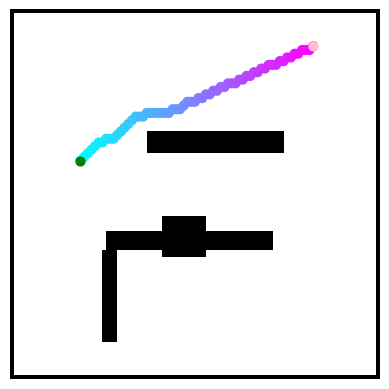

In [10]:
# Get a batch of data
data = next(iter(train_loader))
maps = data['map']
mask = data['astar_mask']

sample_map = maps[0].numpy()
sample_path = data['astar_path'][0].numpy()
sample_mask = data['astar_mask'][0].numpy()

highlight_indices = [[0, 2], [6, 7, 8]]

# Visualize with mask and highlighting
render(
    sample_map,
    path=sample_path,
    mask=sample_mask,
    gradient=True,
    legend=False,
    highlight_indices=None, # or highlight_indices
    title="Path Visualization"
)

# Modeling

# Diffusion Model

In [11]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


Build Diffusion Model Architecture


In [12]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.01, timesteps = 150, map_shape=None):
        # start_schedule: starting value for beta scheduling
        self.start_schedule = start_schedule
        # end_schedule: ending value for beta scheduling
        self.end_schedule = end_schedule
        # timesteps: number of timesteps in the diffusion process
        self.timesteps = timesteps

        """
        if
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]


        """
        # Create an array of beta values linearly spaced between start and end schedules
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        # Compute alpha values as 1 minus the corresponding beta values
        self.alphas = 1 - self.betas
        # Compute the cumulative product of alphas to use in diffusion calculations
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        # Scaling factor for noise
        self.noise_scale = 20.0


        # Calculate the center based on the map dimensions 
        # so noise is around center of map not a the (0,0) bottom left corner
        self.map_center_x = map_shape[1] / 2  # Center along width
        self.map_center_y = map_shape[0] / 2  # Center along height

        self.line_guess = None
        
    def calculate_guess(self, start_point, end_point, path_length, device):
        """
        Compute a straight-line guess with a uniform distribution.
        
        Args:
            start_point (Tensor): Start point of the line [batch, 2].
            end_point (Tensor): End point of the line [batch, 2].
            path_length (int): Number of points in the path.
            device (str): Device for computation (CPU/GPU).
        
        Returns:
            Tensor: Straight-line path distribution [batch, path_length, 2].
        """
        # Ensure t_vals has the correct shape for broadcasting
        t_vals = torch.linspace(0, 1, path_length, device=device).unsqueeze(0).unsqueeze(-1)  # [1, path_length, 1]
        
        # Broadcast t_vals to match batch size
        t_vals = t_vals.expand(start_point.size(0), path_length, 1)  # [batch, path_length, 1]

        # Add an extra dimension to start_point and end_point for broadcasting
        start_point = start_point.unsqueeze(1)  # [batch, 1, 2]
        end_point = end_point.unsqueeze(1)      # [batch, 1, 2]

        # Interpolate between start_point and end_point
        line = (1 - t_vals) * start_point + t_vals * end_point  # [batch, path_length, 2]

        return line
    
    def noise_guess_distribution(self, line, sigma_parallel, sigma_perp, device):
        """
        Create a noise distribution for the line.

        Args:
            line (Tensor): Straight-line path [path_length, 2] or [batch, path_length, 2].
            sigma_parallel (float): Parallel noise standard deviation.
            sigma_perp (float): Perpendicular noise standard deviation.
            device (str): Device for computation (CPU/GPU).

        Returns:
            List[torch.distributions.MultivariateNormal]: A list of distributions for sampling noise.
        """
        if line.dim() == 2:
            line = line.unsqueeze(0)  # Add batch dimension if it's missing

        batch_size, path_length, _ = line.size()

        # Normalize parallel direction (along the line)
        u_parallel = line[:, -1] - line[:, 0]  # Vector from start to end of line [batch, 2]
        u_parallel = u_parallel / torch.norm(u_parallel, dim=-1, keepdim=True)  # Normalize [batch, 2]

        # Compute perpendicular direction (90-degree rotation)
        u_perp = torch.stack([-u_parallel[:, 1], u_parallel[:, 0]], dim=-1)  # Rotate 90 degrees [batch, 2]

        # Construct covariance matrix for each point
        cov_parallel = sigma_parallel**2
        cov_perp = sigma_perp**2

        # Rotation matrix formed by [u_parallel, u_perp] at each batch
        rotation_matrix = torch.stack([u_parallel, u_perp], dim=-1)  # [batch, 2, 2]

        # Diagonal covariance in the rotated frame
        diag_cov = torch.diag_embed(torch.tensor([cov_parallel, cov_perp], device=device))  # [1, 2, 2]
        diag_cov = diag_cov.repeat(batch_size, 1, 1)  # Match batch size

        # Covariance in the original frame
        covariance = rotation_matrix @ diag_cov @ rotation_matrix.transpose(-1, -2)  # [batch, 2, 2]

        # Create the distribution for each point on the line
        noise_distributions = []
        for batch_idx in range(batch_size):
            batch_distributions = []
            for i in range(path_length):
                mean = line[batch_idx, i, :]  # Mean for this point [2]
                cov = covariance[batch_idx]  # Covariance for this batch [2, 2]
                dist = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)
                batch_distributions.append(dist)
            noise_distributions.append(batch_distributions)

        return noise_distributions

    def forward_guess(self, x_0, t, A, B, sigma_parallel, sigma_perp, device):
        """
        Forward diffusion process with line-based noise, allowing different A and B per batch.

        Args:
            x_0 (Tensor): Original path data [batch, path_length, 2].
            t (Tensor): Timesteps [batch].
            A (Tensor): Start points [batch, 2].
            B (Tensor): End points [batch, 2].
            sigma_parallel (float): Parallel noise standard deviation.
            sigma_perp (float): Perpendicular noise standard deviation.
            device (str): Device for computation (CPU/GPU).

        Returns:
            x_t (Tensor): Transformed path at timestep t [batch, path_length, 2].
            actual_noise (Tensor): Noise added to x_0 to generate x_t [batch, path_length, 2].
        """
        batch_size = x_0.size(0)  # Get the batch size
        path_length = x_0.size(1)  # Get the number of points in the path

        # Generate the structured line for each batch element
        self.line_guess = torch.stack([
            self.calculate_guess(A[i].unsqueeze(0), B[i].unsqueeze(0), path_length, device).squeeze(0)
            for i in range(batch_size)
        ])  # [batch, path_length, 2]

        # Generate structured noise distributions for the entire batch
        self.distributions = self.noise_guess_distribution(self.line_guess, sigma_parallel, sigma_perp, device)

        # Sample noise for each batch element
        noise = torch.stack([
            torch.stack([dist.sample() for dist in batch_dist]) for batch_dist in self.distributions
        ])  # [batch, path_length, 2]

        # Compute diffusion parameters
        sqrt_alpha_t = torch.sqrt(self.alphas_cumprod[t.cpu()]).unsqueeze(-1).unsqueeze(-1).to(device)  # [batch, 1, 1]
        sqrt_one_minus_alpha_t = torch.sqrt(1 - self.alphas_cumprod[t.cpu()]).unsqueeze(-1).unsqueeze(-1).to(device)  # [batch, 1, 1]
       
        # Scale the noise and compute x_t
        actual_noise = sqrt_one_minus_alpha_t * noise
        x_t = sqrt_alpha_t * x_0 + actual_noise

        return x_t, actual_noise

    def get_line_guess(self):
        return self.line_guess

    def forward(self, x_0, t, mask, device):
        """
        Simulate the forward diffusion process (noising)

        x_0: original path data (Batch, Channel, Height, Width)
        t: timestep indices for the diffusion (Batch,)
        mask: Boolean tensor indicating valid path points.
        """

        # Calculate the center of the map for noise mean and move it to the same device
        self.map_center = torch.tensor([self.map_center_x, self.map_center_y], device=device)
        
        # Generate noise with the same shape as the input data with the mean being center of map
        noise = torch.randn_like(x_0) #* self.noise_scale  #+ self.map_center.to(device)


        # Get the square root of alphas_cumprod for the given timesteps
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        # Get the square root of (1 - alphas_cumprod) for the given timesteps
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)

        # Calculate the mean of the diffusion process at time t
        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        # Calculate the variance contribution from the noise
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        # Calculate final noisy output, ensuring EOS (-1) tokens remain unchanged
        noisy_output = mean + variance
        noisy_output = torch.where(mask.unsqueeze(-1).to(device), noisy_output, torch.full_like(noisy_output, -1.0))

        # Return the noisy version of the input along with the generated noise
        return noisy_output, noise.to(device)


    @torch.no_grad()
    def backward(self, x, t, map_data, start_points, end_points, model, sparse_path=None):
        """
        Simulate the reverse diffusion process (denoising)

        Calls the model to predict the noise in the path and returns
        the denoised path.
        Applies noise to this path, if we are not in the last step yet.

        x: current noisy path
        t: timestep indices
        model: model used to estimate the original noise in the path
        """

        # Get model predictions for noise at each timestep
        predicted_noise = model(x, map_data, start_points, end_points, t, sparse_path)
        
        # Extract the beta value for each timestep
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        # Compute necessary components for the denoising step
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)

        # Calculate the mean of the denoised image
        mean = sqrt_recip_alphas_t * (x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        # Add noise only if not the last timestep
        if (t > 0).all():
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise
            return mean + variance
        else:
            return mean

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        Static method to extract values from a tensor based on indices
        and reshape the result to match input dimensions

        pick the values from vals
        according to the indices stored in `t`
        """
        # Gather the values from `values` tensor at indices provided by `t`
        result = values.gather(-1, t.cpu())
        """
        if
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3

        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)

        """
        # Reshape the result to match the input dimensions for broadcasting
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)



In [13]:
class MultiLevelDiffusionModel:
    def __init__(self, levels, start_schedules, end_schedules, timesteps_per_level, map_shape):
        self.levels = levels
        self.models = [
            DiffusionModel(start_schedule=start_schedules[i], end_schedule=end_schedules[i], timesteps=timesteps_per_level[i], map_shape=map_shape)
            for i in range(levels)
        ]

    def forward_guess(self, x_0, level, t, A, B, sigma_parallel, sigma_perp, device):
        return self.models[level].forward_guess(x_0, t, A, B, sigma_parallel, sigma_perp, device)
    
    def get_line_guess(self, level):
        return self.models[level].get_line_guess()

    def forward(self, x_0, level, t, mask, device):
        return self.models[level].forward(x_0, t, mask, device)

    def backward(self, level, x, t, map_embeddings, start_points, end_points, model, sparse_path=None):
        return self.models[level].backward(x, t, map_embeddings, start_points, end_points, model, sparse_path)

In [14]:
# Helper function to get a sample map and path
def get_sample_map_and_path(dataset):
    sample_data = next(iter(DataLoader(dataset, batch_size=1, shuffle=True)))
    return sample_data['map'].squeeze(0), sample_data['astar_path'].squeeze(0), sample_data['astar_mask'].squeeze(0), sample_data['start_point'].squeeze(0), sample_data['end_point'].squeeze(0)

In [15]:
def resample_path(batch_path_tensor, batch_mask_tensor, target_length=100):
    """
    Resample a batch of path tensors to a uniform number of points based on valid points indicated by a mask.

    This function processes each path in the batch individually, using linear interpolation over the indices
    of valid path points to create a uniformly sampled path with a specified number of waypoints.
    The mask is used to filter out invalid points, ensuring only relevant data points are included in the resampling process.
    A new mask is generated where all entries are `True` since all resampled points are considered valid.

    Args:
        batch_path_tensor (torch.Tensor): A batch of path tensors of shape [batch_size, sequence_length, num_features].
        batch_mask_tensor (torch.Tensor): A batch of boolean masks of shape [batch_size, sequence_length].

    Returns:
        uniform_paths (torch.Tensor): The batch of resampled path tensors with `target_length` waypoints.
        new_masks (torch.Tensor): Batch of boolean tensors of size [batch_size, target_length] with all True values.
    """
    batch_size = batch_path_tensor.size(0)
    num_features = batch_path_tensor.size(2)

    # Initialize tensor to hold resampled paths and new masks
    uniform_paths = torch.empty(batch_size, target_length, num_features, dtype=batch_path_tensor.dtype, device=batch_path_tensor.device)
    # Create a new mask (all true because all are valid sampled points)
    new_masks = torch.ones(batch_size, target_length, dtype=torch.bool, device=batch_path_tensor.device)

    for i in range(batch_size):
        path_tensor = batch_path_tensor[i]
        mask_tensor = batch_mask_tensor[i]

        # Only consider valid points as per the mask
        valid_points = path_tensor[mask_tensor]

        if len(valid_points) == 0:
            # If no valid points, handle edge case (e.g., by filling with zeros or repeating last valid point)
            uniform_paths[i] = torch.zeros((target_length, num_features), dtype=path_tensor.dtype, device=path_tensor.device)
        else:
            # Calculate the indices for uniform sampling
            indices = torch.linspace(0, len(valid_points) - 1, target_length, dtype=torch.long, device=batch_path_tensor.device)

            # Sample the points uniformly
            uniform_paths[i] = valid_points[indices]

    return uniform_paths, new_masks

In [16]:
def select_closest_and_furthest_points(noisy_paths, start_points, num_points, device, mask=None):
    """
    Selects the closest 'num_points' to the 'start_points' from 'noisy_paths' and identifies the remaining points as the furthest.
    
    Args:
        noisy_paths (torch.Tensor): Tensor of shape [batch_size, 2, sequence_length] containing noisy path data.
        start_points (torch.Tensor): Tensor of shape [batch_size, 2] containing start points for each path.
        num_points (int): Number of closest points to select.
        device (torch.device): Device on which to perform the computations.
        mask (torch.Tensor, optional): Tensor of shape [batch_size, sequence_length] containing mask data.
    
    Returns:
        tuple: A tuple containing:
            - closest_points (torch.Tensor): The subset of points closest to the start points.
            - closest_indices (torch.Tensor): The indices of these closest points in the original noisy_paths tensor.
            - furthest_points (torch.Tensor): The remaining points after selecting the closest points.
            - furthest_indices (torch.Tensor): The indices of these remaining points in the original noisy_paths tensor.
            - closest_mask (torch.Tensor, optional): The corresponding mask for the closest points (if mask is provided).
    """
    noisy_paths = noisy_paths.to(device)
    start_points = start_points.to(device)

    # Calculate the differences for each point in noisy_paths with the start_points
    differences = noisy_paths - start_points.unsqueeze(-1)  # Expanding start_points for broadcasting

    # Compute the Euclidean distance from start points
    distances = torch.sqrt(torch.sum(differences ** 2, dim=1))

    # Find the indices of the closest 'num_points' distances
    _, closest_indices = torch.topk(distances, num_points, largest=False, dim=-1)

    # Select the corresponding closest points using the indices
    closest_points = torch.gather(noisy_paths, 2, closest_indices.unsqueeze(1).expand(-1, 2, -1))

    # Create a mask to identify the remaining points
    full_indices = torch.arange(distances.size(-1), device=device).expand_as(distances)
    furthest_mask = torch.ones_like(distances, dtype=torch.bool)
    furthest_mask.scatter_(1, closest_indices, False)

    # Use the mask to select the furthest points
    furthest_indices = full_indices[furthest_mask].view(distances.size(0), -1)
    furthest_points = torch.gather(noisy_paths, 2, furthest_indices.unsqueeze(1).expand(-1, 2, -1))

    closest_mask = None
    if mask is not None:
        mask = mask.to(device)

        # Ensure mask has the correct shape for gather
        mask = mask.unsqueeze(1)  # Shape becomes [batch_size, 1, sequence_length]

        # Gather the corresponding mask values for the closest points
        closest_mask = torch.gather(mask, 2, closest_indices.unsqueeze(1).expand(-1, mask.size(1), -1))

        # Remove the extra dimension to make the shape [batch_size, sequence_length]
        closest_mask = closest_mask.squeeze(1)

    return closest_points, closest_indices, furthest_points, furthest_indices, closest_mask



In [17]:
# Example usage
batch_size = 5
sequence_length = 175
num_points = 50  # Number of closest points to select, assume this comes from target_lengths[level]

# Simulate data
noisy_paths = torch.rand(batch_size, 2, sequence_length)
start_points = torch.rand(batch_size, 2)
masks = torch.rand(batch_size, sequence_length)

# Call the function
closest_points, closest_indices, furthest_points, furthest_indices, closest_mask = select_closest_and_furthest_points(noisy_paths, start_points, num_points, device, mask=masks)

print("Closest Points Shape:", closest_points.shape)  # Should be [batch_size, 2, num_points]
print("Closest Points Indices Shape:", closest_indices.shape)  # Should be [batch_size, num_points]
print("Furthest Points Shape:", furthest_points.shape)
print("Furthest Points Indices:", furthest_indices.shape)
print("New mask for closest points", closest_mask.shape)

Closest Points Shape: torch.Size([5, 2, 50])
Closest Points Indices Shape: torch.Size([5, 50])
Furthest Points Shape: torch.Size([5, 2, 125])
Furthest Points Indices: torch.Size([5, 125])
New mask for closest points torch.Size([5, 50])


In [18]:
def calculate_schedules(initial_start, initial_end, num_levels):
    """
    Calculate the start and end schedules for diffusion models across multiple levels.

    Each subsequent level starts with the same minimum variance as the first level but ends at half
    the maximum variance of the previous level.

    Args:
    - initial_start (float): The starting variance (beta) for the first level, consistent across all levels.
    - initial_end (float): The ending variance (beta) for the first level.
    - num_levels (int): Total number of diffusion levels.

    Returns:
    - tuple of (list, list): A tuple containing two lists:
        - start_schedules: Start variances for each level.
        - end_schedules: End variances for each level, each half of the end variance of the previous level.
    """
    # Initialize the start schedules for all levels with the initial start variance
    start_schedules = [initial_start] * num_levels
    # Initialize end schedules where the first level has the initial end variance
    end_schedules = [initial_end] + [0] * (num_levels - 1)

    for level in range(1, num_levels):
        # Set the end schedule for the current level to half of the end schedule of the previous level
        end_schedules[level] = round(end_schedules[level-1] / 2, 6)

    return start_schedules, end_schedules

# Example usage
num_levels = 3
initial_start = 0.0001
initial_end = 0.01

start_schedules, end_schedules = calculate_schedules(initial_start, initial_end, num_levels)
print("Start Schedules:", start_schedules)
print("End Schedules:", end_schedules)

Start Schedules: [0.0001, 0.0001, 0.0001]
End Schedules: [0.01, 0.005, 0.0025]


Visualize forward Noising Processing and Selecting Closest Noised Points in a Receding Manner

In [19]:
def generate_receded_noised_paths(
    multi_level_diffusion_model, 
    path_tensor, 
    mask_tensor, 
    start_point_tensor, 
    target_lengths, 
    levels, 
    num_display_images=5, 
    guess_dist=False,
    end_point_tensor=None,
    sigma_parallel=.2, 
    sigma_perp=.2
):
    """
    Generate noised paths and recede to target lengths across multiple levels.
    """
    noised_paths_per_level = []
    receded_original_path_per_level = []
    timesteps_label_tracker = []
    line_guesses_per_level = []

    for level in range(levels):
        t_max = multi_level_diffusion_model.models[level].timesteps - 1
        timesteps = torch.linspace(0, t_max, num_display_images).long()

        if level == 0:
            # Resample the path to the target length for the first level
            resampled_path, resampled_mask = resample_path(path_tensor, mask_tensor, target_length=target_lengths[level])
        else:
            
            path_tensor = path_tensor.permute(0,2,1) 

            # Select the closest points from the previous noised path
            closest_points, closest_indices, _, _, closest_mask = select_closest_and_furthest_points(
                path_tensor, start_point_tensor, target_lengths[level], device=path_tensor.device, mask=mask_tensor
            )
            
            resampled_path = closest_points.permute(0,2,1)
            resampled_mask = closest_mask

        # Forward noising
        path_viz_batch = resampled_path.repeat(num_display_images, 1, 1)
        line_guess = None
        if guess_dist:
            # Need to make have a start and end point for each path
            start_point_batch = start_point_tensor.repeat(num_display_images, 1,)
            end_point_batch = end_point_tensor.repeat(num_display_images, 1)

            noisy_paths, _ = multi_level_diffusion_model.forward_guess(path_viz_batch, 
                                                                       level, 
                                                                       timesteps, 
                                                                       start_point_batch,
                                                                       end_point_batch, 
                                                                       sigma_parallel, 
                                                                       sigma_perp, 
                                                                       device=path_tensor.device)
            
            line_guess = multi_level_diffusion_model.get_line_guess(level)
            line_guesses_per_level.append(line_guess)
        else:
            noisy_paths, _ = multi_level_diffusion_model.forward(path_viz_batch, level, timesteps, resampled_mask, device=path_tensor.device)

        # Store results
        noised_paths_per_level.append(noisy_paths)
        receded_original_path_per_level.append(resampled_path)
        timesteps_label_tracker.append(timesteps)

        # Update path_tensor for the next level
        path_tensor = resampled_path
        mask_tensor = resampled_mask

    if guess_dist:
        return noised_paths_per_level, receded_original_path_per_level, timesteps_label_tracker, line_guesses_per_level
    
    return noised_paths_per_level, receded_original_path_per_level, timesteps_label_tracker


def visualize_forward_noising(
    map_tensor, original_paths, noised_paths_per_level, levels, timesteps_label_tracker, line_guesses=None
):
    """
    Visualize forward noising process and receding points for each level.
    Args:
    - map_tensor (torch.Tensor): Map tensor for context visualization.
    - noised_paths_per_level (list): Noised paths across levels.
    - receded_paths_per_level (list): Receded paths across levels.
    - timesteps_per_level (list): Timesteps for visualization at each level.
    - levels (int): Number of levels in the diffusion model.
    """
    # Total number of subplots: levels x batch_size
    batch_size = noised_paths_per_level[0].shape[0]  # Assuming consistent batch size across levels
    fig, axes = plt.subplots(levels, batch_size+1, figsize=(15, 5 * levels), squeeze=False)

    for level in range(levels):

        # Visualize original path
        render(
            map=map_tensor.numpy(),
            path=noised_paths_per_level[level][0].cpu().numpy(),
            title=f"Level {level} - Receded Original Path",
            gradient=True,
            ax=axes[level, 0]
        )


        for batch_idx in range(batch_size):

            # Visualize forward noising
            render(
                map=map_tensor.numpy(),
                path=noised_paths_per_level[level][batch_idx].cpu().numpy(),
                title=f"Level {level} - Noising Step {timesteps_label_tracker[level][batch_idx]}",
                gradient=True,
                line_guess= line_guesses[level][batch_idx] if line_guesses is not None else None,
                ax=axes[level, batch_idx+1]
            )


    plt.tight_layout()
    plt.show()


Example for Forward Noising for Multi Level Diffusion Model

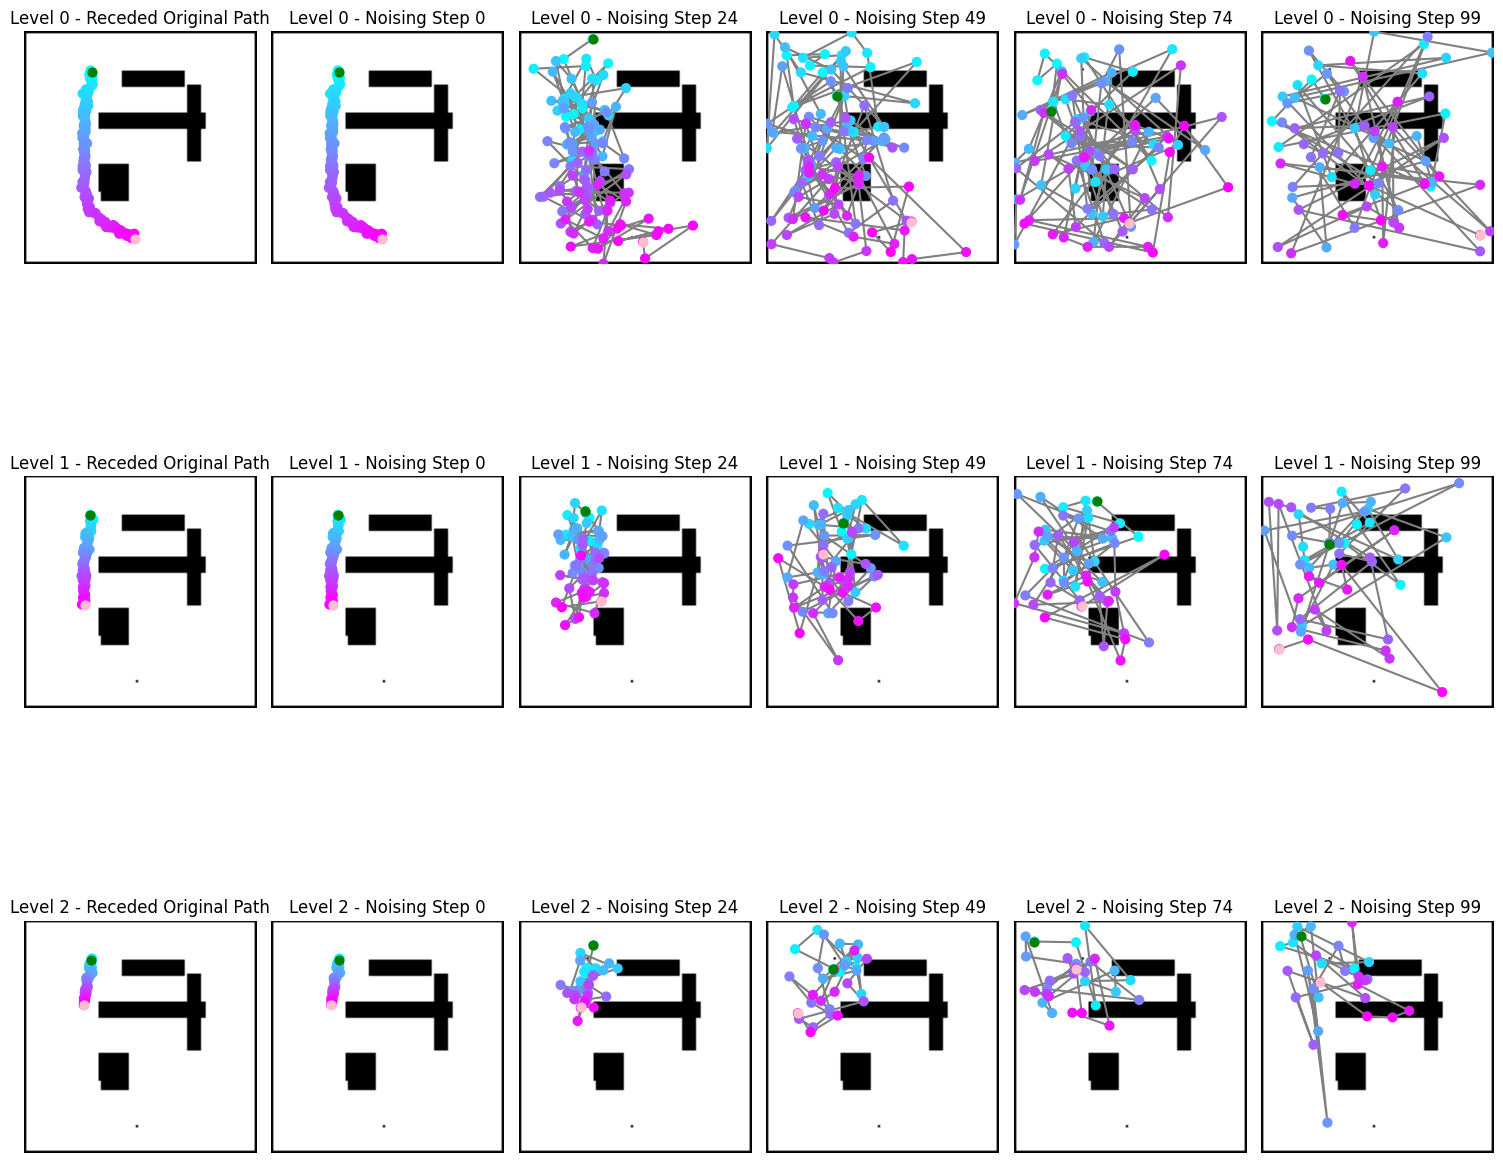

In [20]:
# Example setup for MultiLevelDiffusionModel
levels = 3
target_lengths = [128, 64, 32]
timesteps_per_level = [100, 100, 100]

# Initialize the MultiLevelDiffusionModel
multi_level_diffusion_model = MultiLevelDiffusionModel(levels, start_schedules, end_schedules, timesteps_per_level, map_shape=MAP_SHAPE)

# Generate a batch of full resolution paths with reduced points for initial levels
map_tensor, path_tensor, mask_tensor, start_point_tensor, _ = get_sample_map_and_path(train_dataset)  # Replace None with your actual dataset

path_tensor = path_tensor.unsqueeze(0)
mask_tensor = mask_tensor.unsqueeze(0)
start_point_tensor = start_point_tensor = start_point_tensor.unsqueeze(0)

# Generate noised and receded paths
noised_paths, receded_original_path_per_level, timesteps_label_tracker = generate_receded_noised_paths(
    multi_level_diffusion_model,
    path_tensor,
    mask_tensor,
    start_point_tensor,
    target_lengths=[128, 64, 32],
    levels=3
)

# Visualize forward noising and receding
visualize_forward_noising(
    map_tensor,
    receded_original_path_per_level,
    noised_paths,
    levels=3,
    timesteps_label_tracker=timesteps_label_tracker
)


Example for Single Level Diffusion Forward Noising to **Gausian Distribution**

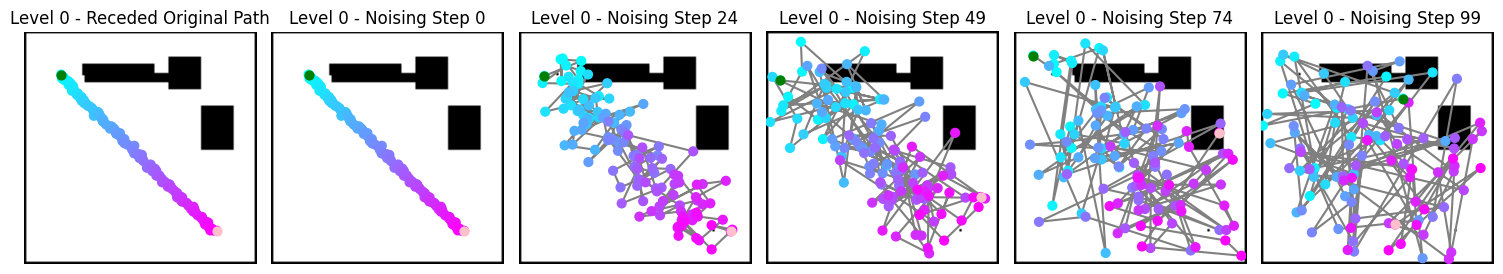

In [21]:
# Example setup for MultiLevelDiffusionModel
levels = 1
target_lengths = [128]
timesteps_per_level = [100]
start_schedules = [.0001]
end_schedules = [0.005]

# Initialize the MultiLevelDiffusionModel
multi_level_diffusion_model = MultiLevelDiffusionModel(levels, start_schedules, end_schedules, timesteps_per_level, map_shape=MAP_SHAPE)

# Generate a batch of full resolution paths with reduced points for initial levels
map_tensor, path_tensor, mask_tensor, start_point_tensor, _ = get_sample_map_and_path(train_dataset)  # Replace None with your actual dataset

path_tensor = path_tensor.unsqueeze(0)
mask_tensor = mask_tensor.unsqueeze(0)
start_point_tensor = start_point_tensor = start_point_tensor.unsqueeze(0)

# Generate noised and receded paths
noised_paths, receded_original_path_per_level, timesteps_label_tracker = generate_receded_noised_paths(
    multi_level_diffusion_model,
    path_tensor,
    mask_tensor,
    start_point_tensor,
    target_lengths=[128],
    levels=1
)

# Visualize forward noising and receding
visualize_forward_noising(
    map_tensor,
    receded_original_path_per_level,
    noised_paths,
    levels=1,
    timesteps_label_tracker=timesteps_label_tracker
)

Example for Single Level Diffusion Forward Noising to **Line Guess Distribution**

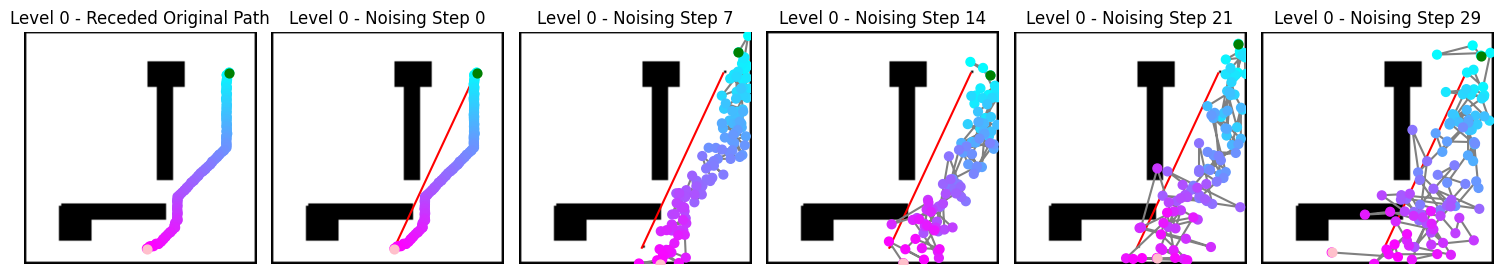

In [22]:
# Example setup for MultiLevelDiffusionModel
levels = 1
target_lengths = [128]
timesteps_per_level = [30]
start_schedules = [.0001]
end_schedules = [.1]
sigma_parallel =.2
sigma_perp =.2

# Initialize the MultiLevelDiffusionModel
multi_level_diffusion_model = MultiLevelDiffusionModel(levels, start_schedules, end_schedules, timesteps_per_level, map_shape=MAP_SHAPE)

# Generate a batch of full resolution paths with reduced points for initial levels
map_tensor, path_tensor, mask_tensor, start_point_tensor, end_point_tensor = get_sample_map_and_path(train_dataset)  # Replace None with your actual dataset

path_tensor = path_tensor.unsqueeze(0)
mask_tensor = mask_tensor.unsqueeze(0)
start_point_tensor = start_point_tensor.unsqueeze(0)
end_point_tensor = end_point_tensor.unsqueeze(0)

# Generate noised and receded paths
noised_paths, receded_original_path_per_level, timesteps_label_tracker, line_guesses = generate_receded_noised_paths(
    multi_level_diffusion_model,
    path_tensor,
    mask_tensor,
    start_point_tensor,
    end_point_tensor = end_point_tensor,
    target_lengths=[128],
    levels=1, 
    guess_dist=True, 
    sigma_parallel=sigma_parallel, 
    sigma_perp=sigma_perp
)

# Visualize forward noising and receding
visualize_forward_noising(
    map_tensor,
    receded_original_path_per_level,
    noised_paths,
    levels=1,
    timesteps_label_tracker=timesteps_label_tracker, 
    line_guesses=line_guesses
)

Unet

In [27]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
      Class for generating sinusoidal position embeddings based on the input time step
    """
    def __init__(self, dim):
        super().__init__()
         # Dimensionality of the time embeddings
        self.dim = dim

    def forward(self, time):
        # Get the device (CPU/GPU) of the input tensor
        device = time.device
        # Divide the embedding dimension in half
        half_dim = self.dim // 2
        # Scaling factor for the embeddings
        embeddings = math.log(10000) / (half_dim - 1)
        # Generate exponential steps
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
         # Scale the steps by the input time tensor
        embeddings = time[:, None] * embeddings[None, :]
         # Apply sine and cosine
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # Return the final time embedding
        return embeddings

Sinusoidal Embeddings Example

Time step 0: Embedding: tensor([[0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]])
Time step 1: Embedding: tensor([[2.4740e-01, 2.4997e-02, 2.5000e-03, 2.5000e-04, 2.5000e-05, 9.6891e-01,
         9.9969e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00]])
Time step 2: Embedding: tensor([[4.7943e-01, 4.9979e-02, 5.0000e-03, 5.0000e-04, 5.0000e-05, 8.7758e-01,
         9.9875e-01, 9.9999e-01, 1.0000e+00, 1.0000e+00]])
Time step 3: Embedding: tensor([[6.8164e-01, 7.4930e-02, 7.4999e-03, 7.5000e-04, 7.5000e-05, 7.3169e-01,
         9.9719e-01, 9.9997e-01, 1.0000e+00, 1.0000e+00]])
Time step 4: Embedding: tensor([[8.4147e-01, 9.9833e-02, 9.9998e-03, 1.0000e-03, 1.0000e-04, 5.4030e-01,
         9.9500e-01, 9.9995e-01, 1.0000e+00, 1.0000e+00]])


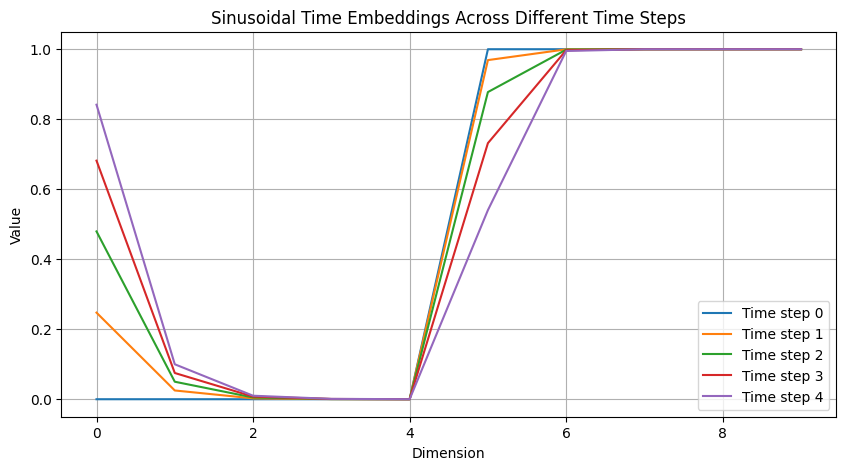

In [28]:
# Initialize the embedding generator
embedding_generator = SinusoidalPositionEmbeddings(dim=10)
# Generate time steps (for example, 5 time steps) Normalized time steps from 0 to 1
timesteps = torch.linspace(0, 1,5)
# Generate embeddings for each time step
time_embeddings = [embedding_generator.forward(timestep.unsqueeze(0)) for timestep in timesteps]

# Print the embeddings
for idx, embedding in enumerate(time_embeddings):
    print(f"Time step {idx}: Embedding: {embedding}")

plt.figure(figsize=(10, 5))
for i, embedding in enumerate(time_embeddings):
    plt.plot(embedding[0].numpy(), label=f'Time step {i}')
plt.title('Sinusoidal Time Embeddings Across Different Time Steps')
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
class MapEmbeddingExtractor(nn.Module):
    def __init__(self, input_channels=1, output_dim=512):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample feature maps
        self.fc = nn.Linear(128 * 25 * 25, output_dim) # Assuming map starts as 100x100!!

    def forward(self, x):
        # x shape: [batch_size, channels, height, width]
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Convolution -> BatchNorm -> ReLU -> Pooling
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Another layer of processing
        x = x.view(x.size(0), -1)  # Flatten the feature map
        x = self.fc(x)  # Fully connected layer to reduce dimensions
        return x
    
class SparsePathEmbedding(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.embedding = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        # Flatten the output across the sequence length dimension
        # This assumes x is [batch_size, features, sequence_length]
        # Resulting shape will be [batch_size, features * sequence_length]
        flattened = embedded.flatten(start_dim=1)
        return flattened
    

class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims):
        super().__init__()
        self.conv1 = nn.Conv1d(channels_in, channels_out, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels_out, channels_out, kernel_size=3, padding=1)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_embedding_dims, channels_out),
            nn.ReLU(),
        )
        self.residual = nn.Conv1d(channels_in, channels_out, kernel_size=1) if channels_in != channels_out else nn.Identity()
        self.relu = nn.ReLU()

    def forward(self, x, t_emb):

        # Time embedding
        time_emb = self.time_mlp(t_emb).unsqueeze(-1)

        # Expand time_emb to match spatial dimensions of x
        time_emb = time_emb.expand(-1, -1, x.size(2))  # Match the sequence length of x

        # First convolution
        out = self.relu(self.conv1(x) + time_emb)
        # Second convolution
        out = self.relu(self.conv2(out) + time_emb)
        # Add residual connection
        return out + self.residual(x)


class UNet(nn.Module):
    def __init__(self, input_channels, map_emb_dims, time_embedding_dims, sparse_path_dims=None, level=0, start_end_points_dims=4):
        super().__init__()

        # Initialize the map embedding extractor
        self.map_embedding_extractor = MapEmbeddingExtractor(input_channels=1, output_dim=map_emb_dims)
        
        # Sum of input channels, map embedding dimensions, and point dimensions
        total_input_channels = input_channels + map_emb_dims + start_end_points_dims

        if sparse_path_dims:
            # Embedding size for sparse path
            sparse_path_emb_dim = 128
            # Initialize the sparse path embedding with appropriate sequence length
            self.sparse_path_embedding = SparsePathEmbedding(sparse_path_dims, sparse_path_emb_dim // 2)
            # Add the dimensions of the sparse path embedding (output from embedding layer)
            total_input_channels += sparse_path_emb_dim


        # Define channel depth based on level
        base_channels = 32  # Start with a smaller number of channels at lower levels
        # Increase number of blocks for higher levevls
        num_blocks = max(2, 7 - level)  # Ensuring at least one block

        # Time embedding
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbeddings(time_embedding_dims),
            nn.Linear(time_embedding_dims, time_embedding_dims),
            nn.ReLU(),
        )

        # Generate a list of channel sizes that increases with each block
        sequence_channels = [base_channels * 2**i for i in range(num_blocks)]
        
        # Initial convolution layer
        self.conv1 = nn.Conv1d(total_input_channels, sequence_channels[0], 3, padding=1)
           
        # Downsampling blocks
        self.down_blocks = nn.ModuleList([
            nn.Sequential(
                Block(sequence_channels[i], sequence_channels[i+1], time_embedding_dims),
                Downsample1d(sequence_channels[i+1])
            )
            for i in range(len(sequence_channels) - 1)
        ])

        # Mid blocks
        self.mid_blocks = nn.ModuleList([
            Block(sequence_channels[-1], sequence_channels[-1], time_embedding_dims),
            Block(sequence_channels[-1], sequence_channels[-1], time_embedding_dims),
        ])


        # Upsampling blocks
        self.up_blocks = nn.ModuleList([
            nn.Sequential(
                Upsample1d(sequence_channels[i+1]),
                Block(sequence_channels[i+1] * 2, sequence_channels[i], time_embedding_dims)
            )
            for i in reversed(range(len(sequence_channels) - 1))
        ])

        # # Create a series of Blocks for processing features
        # self.blocks = nn.ModuleList([Block(sequence_channels[i], sequence_channels[i+1], time_embedding_dims) 
        #                              for i in range(len(sequence_channels)-1)])
        
        # Output 2 channels for X and Y coordinates
        # self.final_conv = nn.Conv1d(sequence_channels[-1], 2, 1)

        # Final convolution
        self.final_conv = nn.Conv1d(sequence_channels[0], 2, kernel_size=1)

        # print(f"LEVEL {level} -----------------------------")
        # print(f"num blocks {num_blocks}")
        # print(f"sequence channels {sequence_channels}")
        # print(f"blocks {self.blocks}")

    def forward(self, path_data, map_data, start_points, end_points, t, sparse_path=None):
        
        # Extract map embeddings
        map_embeddings = self.map_embedding_extractor(map_data)

        # Concatinate and Repeat start and end points to match the path data dimensions [batch, points, repeated]
        start_end_points_features = torch.cat([start_points, end_points], dim=1).unsqueeze(-1).repeat(1, 1, path_data.size(2))

        # Expand and repeat map embeddings to match path data dimensions
        map_features = map_embeddings.unsqueeze(-1).repeat(1, 1, path_data.size(2))

        # If a sparse path exists for us to condition on
        if sparse_path is not None: 
            # Embed the sparse path
            embedded_sparse_path = self.sparse_path_embedding(sparse_path)
            # Expand and repeat sparse path embeddings to match path data dimensions
            embedded_sparse_path = embedded_sparse_path.unsqueeze(-1).repeat(1, 1, path_data.size(2))
            # Concatenate all features
            x = torch.cat((path_data, map_features, embedded_sparse_path, start_end_points_features), dim=1)
        else:
            # Concatenate all features
            x = torch.cat((path_data, map_features, start_end_points_features), dim=1)
                
        # # Apply the initial convolution to the input
        # x = self.conv1(x)
        
        # # Pass the feature map through each block, incorporating the previous denoised path as conditioning
        # for block in self.blocks:
        #     x = block(x, t)
        
        # # Return the final coordinates after the last convolution
        # return self.final_conv(x)

        # Time embedding
        t_emb = self.time_embedding(t)

        # Initial convolution
        x = self.conv1(x)

        # Downsampling
        skips = []
        for down in self.down_blocks:
            x = down[0](x, t_emb)  # Block
            skips.append(x)
            x = down[1](x)  # Downsample

        # Mid blocks
        for mid_block in self.mid_blocks:
            x = mid_block(x, t_emb)
            
        # Upsampling
        for up, skip in zip(self.up_blocks, reversed(skips)):
            x = up[0](x)  # Upsample
            x = torch.cat([x, skip], dim=1)  # Skip connection
            x = up[1](x, t_emb)  # Block

        # Final convolution
        return self.final_conv(x)

Test the Unet Model

In [30]:
# Define constants for the UNet models
map_emb_dims = 512
input_channels = 2  # XY coordinates for the path data
time_embedding_dims = 128
start_end_points_dims = 4  # Dimensions for flattened start and end points
batch_size = 32
num_levels = 1
target_lengths = [128, 64, 32]

# Initialize lists for models and corresponding noisy paths
unet_models = []
noised_paths = []
saved_sparse_paths_dim = []

# Create UNet models for each level and initialize random noisy paths
for i in range(num_levels):
    # Condition on the furthest points denoised up until now
    sparse_path_dim = (target_lengths[0] - target_lengths[i]) if i > 0 else None
    # Save to easily use later
    saved_sparse_paths_dim.append(sparse_path_dim)
    # Initialize unet model
    unet_model = UNet(input_channels, map_emb_dims, time_embedding_dims, sparse_path_dims=sparse_path_dim, level=i, start_end_points_dims=start_end_points_dims)
    unet_models.append(unet_model.to(device))
    # Simulate noisy paths for this level with dimensions corresponding to target_lengths
    noised_path = torch.rand(batch_size, 2, target_lengths[i]).to(device)
    noised_paths.append(noised_path)

# Initialize random map embeddings and uniform time steps for all paths
# map_embeddings = torch.rand(batch_size, map_emb_dims).to(device)
map_data = torch.rand(batch_size, 1, 100, 100).to(device)  # [batch_size, input_channels, height, width]
time_steps = torch.tensor([0.5] * batch_size).to(device)
denoised_outputs = [None] * num_levels  # To hold outputs from each level for use as conditioning in subsequent levels
# Generate random start and end points for the batch outside the loop
start_point = torch.rand(batch_size, 2).to(device)  
end_point = torch.rand(batch_size, 2).to(device)  

# Evaluate each UNet model on its corresponding level of path complexity
for i, unet_model in enumerate(unet_models):
    print(f"LEVEL {i} ------------------")
    previous_output = None
    if i > 0: 
        # Not using previous output as condition. The preivous output is the noise
        previous_output =  torch.rand(32, 2, saved_sparse_paths_dim[i]).to(device)
    # Run the UNet model for this level
    output = unet_model(noised_paths[i], map_data, start_point, end_point, time_steps, previous_output)
    # Store the output for potential use in the next level
    denoised_outputs[i] = output  
    print(f"Output shape from model at level {i}: {output.shape}")

LEVEL 0 ------------------
Output shape from model at level 0: torch.Size([32, 2, 128])


Function that will call the multiple levels and generate a path

In [32]:
def generate_plan_multi_level(
    sample_map,
    sample_path,
    sample_mask,
    sample_start_point,
    sample_end_point,
    unet_models,
    target_lengths,
    num_levels,
    device,
    num_timestep_display=5,
    visualize=True,
):
    """
    Generate and visualize a plan using the trained models by denoising the path at each level.
    """
    # Resample to the target length of the first level
    current_denoised_path, reduced_mask = resample_path(sample_path, sample_mask, target_length=target_lengths[0])
    
    sample_map = sample_map.unsqueeze(1).to(device)  # Add channel dimension [batch, channel, x, y]
    current_denoised_path = current_denoised_path.unsqueeze(0).to(device)
    reduced_mask = reduced_mask.unsqueeze(0).to(device)
    sample_start_point = sample_start_point.to(device)
    sample_end_point = sample_end_point.to(device)

    denoised_path = None
    ax_count = 0 

    # Store removed points for conditioning at later levels
    saved_points = None

    # Visualization setup
    if visualize:
        fig, axes = plt.subplots(1, num_levels + 2, figsize=(15, 5 * num_levels))

    for level in range(num_levels):
        print(f"Processing Level {level}")
        unet_model = unet_models[level]

        # Get tmax
        t_max = multi_level_diffusion_model.models[level].timesteps - 1
        t_max_tensor = torch.tensor([t_max], device=device)

        # Noise path to t_max
        if level == 0: 
            initial_noisy_path, _ = multi_level_diffusion_model.models[level].forward(current_denoised_path, t_max_tensor, reduced_mask, device)

            # Visualize the noisy path
            if visualize:
                render(
                    map=sample_map.squeeze().cpu().numpy(),
                    path=initial_noisy_path.squeeze().cpu().numpy(),
                    mask=reduced_mask.squeeze().cpu().numpy(),
                    gradient=True,
                    title=f"Level {level} - Noised Path (t_max)",
                    ax=axes[ax_count],
                )
                ax_count += 1

        # Step 2: Denoise to t_max / 2
        t_mid = t_max // 2

        if level == 0: 
            denoised_path = initial_noisy_path.squeeze(0).permute(0, 2, 1)
            conditioning_path = None
        else: 

            # Get the path to condition on from previous level
            closest_points, _, new_conditioning_path, _, _ = select_closest_and_furthest_points(
                denoised_path, sample_start_point, target_lengths[level], device
            )

            # Update saved points
            if saved_points is not None:
                saved_points = torch.cat((new_conditioning_path, saved_points), dim=2)
            else:
                saved_points = new_conditioning_path.clone()

            conditioning_path = saved_points.clone()

            # Update denoised path
            denoised_path = closest_points

        # Denoise each timestep at a time in reverse
        for t in reversed(range(t_max + 1)):
            t_tensor = torch.tensor([t], device=device)
            denoised_path = multi_level_diffusion_model.models[level].backward(
                denoised_path, 
                t_tensor, 
                sample_map, 
                sample_start_point, 
                sample_end_point, 
                unet_model, 
                sparse_path=conditioning_path
            )

            # Stop denoising midway unless last level
            if (t <= t_mid) and (level < (num_levels - 1)):
                # Visualize what the denoised path looks like so far
                if visualize:
                    render(
                        map=sample_map.squeeze().cpu().numpy(),
                        path=denoised_path.permute(0, 2, 1).squeeze(0).cpu().numpy(),
                        mask=reduced_mask.squeeze().cpu().numpy(),
                        gradient=True,
                        title=f"Level {level} - Denoised to t_mid",
                        ax=axes[ax_count],
                    )
                    ax_count += 1
                break 

        
        # Plot the fully denoised path for the final level
        if level == (num_levels - 1):
            if visualize:
                render(
                    map=sample_map.squeeze().cpu().numpy(),
                    path=denoised_path.permute(0, 2, 1).squeeze(0).cpu().numpy(),
                    mask=reduced_mask.squeeze().cpu().numpy(),
                    gradient=True,
                    title=f"Level {level} - Fully Denoised Path",
                    ax=axes[ax_count],
                )
                ax_count += 1

                # Put all the pieces of the path together together
                saved_points = torch.cat((denoised_path, saved_points), dim=2)

                # Visualize full complete path
                render(
                    map=sample_map.squeeze().cpu().numpy(),
                    path=saved_points.permute(0, 2, 1).squeeze(0).cpu().numpy(),
                    mask=reduced_mask.squeeze().cpu().numpy(),
                    gradient=True,
                    title=f"Level {level} - Combined Denoised Path",
                    ax=axes[ax_count],
                )
                ax_count += 1



    plt.tight_layout()
    if visualize:
        plt.show()


def generate_plan(
    sample_map,
    sample_path,
    sample_mask,
    sample_start_point,
    sample_end_point,
    unet_models,
    target_lengths,
    level,
    device,
    num_timestep_display=5,
    visualize=True,
    guess_dist=False,
    sigma_parallel=.2, 
    sigma_perp=.2
):
    """
    Generate and visualize a plan using the trained models by denoising the path at each level.
    """
    # Resample to the target length of the first level
    current_denoised_path, reduced_mask = resample_path(sample_path, sample_mask, target_length=target_lengths[0])
    
    sample_map = sample_map.unsqueeze(1).to(device)  # Add channel dimension [batch, channel, x, y]
    current_denoised_path = current_denoised_path.unsqueeze(0).to(device)
    reduced_mask = reduced_mask.unsqueeze(0).to(device)
    sample_start_point = sample_start_point.to(device)
    sample_end_point = sample_end_point.to(device)

    denoised_path = None
    ax_count = 0 

    # Visualization setup
    if visualize:
        fig, axes = plt.subplots(1, num_timestep_display + 2, figsize=(15, 5 * num_levels))

    print(f"Processing Level {level}")
    unet_model = unet_models[level]

    # Get tmax
    t_max = multi_level_diffusion_model.models[level].timesteps - 1
    t_max_tensor = torch.tensor([t_max], device=device)

    line_guess = None
    if guess_dist:

        current_denoised_path = current_denoised_path.squeeze(0)
        initial_noisy_path, _ = multi_level_diffusion_model.models[level].forward_guess(current_denoised_path, 
                                                                            t_max_tensor, 
                                                                            sample_start_point,
                                                                            sample_end_point, 
                                                                            sigma_parallel, 
                                                                            sigma_perp, 
                                                                            device=device)
                
        line_guess = multi_level_diffusion_model.models[level].get_line_guess()
    else:
        # Noise path to t_max
        initial_noisy_path, _ = multi_level_diffusion_model.models[level].forward(current_denoised_path, t_max_tensor, reduced_mask, device)

    # Visualize the noisy path
    if visualize:
        render(
            map=sample_map.squeeze().cpu().numpy(),
            path=current_denoised_path.squeeze().cpu().numpy(),
            mask=reduced_mask.squeeze().cpu().numpy(),
            gradient=True,
            title=f"Level {level} - Ground Truth Path",
            ax=axes[ax_count],
        )
        ax_count += 1

        render(
            map=sample_map.squeeze().cpu().numpy(),
            path=initial_noisy_path.squeeze().cpu().numpy(),
            mask=reduced_mask.squeeze().cpu().numpy(),
            gradient=True,
            title=f"Level {level} - Noised Path (t_max)",
            ax=axes[ax_count],
            line_guess=line_guess.cpu()
        )
        ax_count += 1


    # Calculate timesteps to display
    timesteps_to_display = set(torch.linspace(1, t_max, steps=num_timestep_display, dtype=torch.long).tolist())

    # Already squeezed. TODO: make sure the forward guess funciton is consistent with forward function dims
    if guess_dist:
        denoised_path = initial_noisy_path.permute(0, 2, 1)
    else:
        denoised_path = initial_noisy_path.squeeze(0).permute(0, 2, 1)

    conditioning_path = None
       
    # Denoise each timestep at a time in reverse
    for t in reversed(range(t_max + 1)):
        t_tensor = torch.tensor([t], device=device)
        denoised_path = multi_level_diffusion_model.models[level].backward(
            denoised_path, 
            t_tensor, 
            sample_map, 
            sample_start_point, 
            sample_end_point, 
            unet_model, 
            sparse_path=conditioning_path
        )

        # Visualize at specific timesteps
        if visualize and t in timesteps_to_display:
            if visualize:
                render(
                    map=sample_map.squeeze().cpu().numpy(),
                    path=denoised_path.permute(0, 2, 1).squeeze(0).cpu().numpy(),
                    mask=reduced_mask.squeeze().cpu().numpy(),
                    gradient=True,
                    title=f"Level {level} - Denoised to {t}",
                    ax=axes[ax_count],
                    line_guess=line_guess.cpu()
                )
                ax_count += 1
             

        
    plt.tight_layout()
    if visualize:
        plt.show()


In [33]:
def obstacle_penalty_loss(predicted_path, map_tensor, time_step, max_timesteps, penalty_weight=1.0):
    """
    Computes an obstacle penalty loss for batches of paths that violate obstacles.
    Penalizes violations closer to timestep 0 more heavily.

    Args:
        predicted_path (Tensor): Predicted path points [batch, 2, path_length].
        map_tensor (Tensor): Obstacle map [batch, 1, height, width], 1 for obstacles, 0 for free space.
        time_step (Tensor): Current time step tensor [batch_size].
        max_timesteps (int): Maximum number of timesteps in the diffusion process.
        penalty_weight (float): Weight for the obstacle penalty loss.

    Returns:
        obstacle_loss (Tensor): Scalar loss penalizing points in obstacle regions.
    """
    batch_size, _, path_length = predicted_path.shape
    _, _, height, width = map_tensor.shape

    # Extract x and y coordinates (long for indexing)
    x_coords = predicted_path[:, 0, :].long()  # X coordinates [batch, path_length]
    y_coords = predicted_path[:, 1, :].long()  # Y coordinates [batch, path_length]

    # Clamp coordinates to ensure they are within map bounds
    x_coords = torch.clamp(x_coords, 0, width - 1)
    y_coords = torch.clamp(y_coords, 0, height - 1)

    # Check if the predicted points lie in obstacle regions
    # Use advanced indexing to map from predicted coordinates to obstacle map values
    obstacle_mask = map_tensor[:, 0, y_coords, x_coords]  # [batch, path_length]

    # Create a timestep weighting: weight is higher as time_step approaches 0
    timestep_weight = 1 - (time_step / max_timesteps).unsqueeze(-1)  # [batch, 1]

    # Calculate obstacle penalty for each batch
    obstacle_penalty = (obstacle_mask * timestep_weight).sum(dim=1)  # Sum penalties over path_length [batch]

    # Average over the batch
    obstacle_loss = penalty_weight * obstacle_penalty.mean()  # Scalar

    return obstacle_loss


# Training

In [37]:
torch.cuda.empty_cache()

In [36]:
del optimizer
del optimizers
del unet_model
del unet_models
del multi_level_diffusion_model

Optimizer 0: Total parameters = 186426274
Epoch: 0 | Train Loss: 2.3137145936489105 | Val Loss: 0.18034428358078003
Model at level 0 saved to ../checkpoints/unet_model_level_0.pth
Processing Level 0


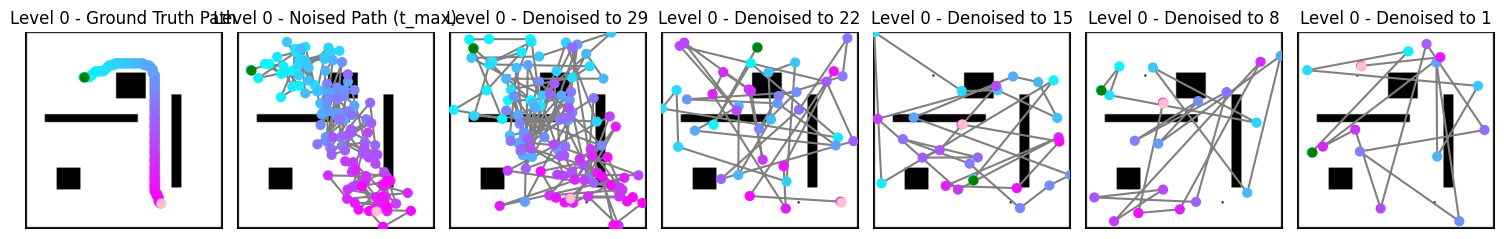

Epoch: 1 | Train Loss: 0.313212596376737 | Val Loss: 0.1470078006386757


In [38]:
torch.autograd.set_detect_anomaly(True)
torch.cuda.empty_cache()

# Training Parameters
num_epochs = 1000 # Number of epochs for training
print_frequency = 1  # Frequency of printing information
visualize_frequency = 20
save_frequency = 20

# Initialize the Unet Model
map_emb_dims = 512
input_channels = 2  # For the path data (x, y)
time_embedding_dims = 128
start_end_points_dims = 4
num_levels = 1

# Variance for first level
initial_start_variance = 0.0001
initial_end_variance = 0.1

# Noising by samping from a line distribution
guess_dist = True
sigma_parallel =.2
sigma_perp =.2


# Calculate Schedules
start_schedules, end_schedules = calculate_schedules(initial_start_variance, initial_end_variance, num_levels)
timesteps_per_level = [30] #, 100, 100]
target_lengths = [128] #, 64, 32]

# Initialize multiple UNet Models and their optimizers
unet_models = []
optimizers = []


for i in range(num_levels):
    # For each level after the first, increase the input channel count to include the output from the previous level
    # Assume each U-Net outputs 2 channels, which will be used as additional inputs for the next level
    sparse_path_dim = target_lengths[0] - target_lengths[i] if i > 0 else None # Not conditioning on sparse path
    unet_model = UNet(input_channels, map_emb_dims, time_embedding_dims, sparse_path_dims=sparse_path_dim, level=i, start_end_points_dims=start_end_points_dims)
    unet_models.append(unet_model.to(device))

    # Combine UNet and ResNet18 parameters for optimization
    optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)

    optimizers.append(optimizer)

# Initialize the MultiLevelDiffusionModel
multi_level_diffusion_model = MultiLevelDiffusionModel(num_levels, start_schedules, end_schedules, timesteps_per_level, map_shape=MAP_SHAPE)

# Verify that the ResNet18 parameters are included in the optimizers
for i, optimizer in enumerate(optimizers):
    total_params = sum(p.numel() for p in optimizer.param_groups[0]['params'])
    print(f"Optimizer {i}: Total parameters = {total_params}")

# Setup a small batch DataLoader for visualization
val_vis_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

# Initialize TensorBoard writer
writer = SummaryWriter("../runs/diffusion_training_loss")

def process_batch(batch,
                  unet_models, 
                  optimizers, 
                  target_lengths,  
                  multi_level_diffusion_model,
                  device, 
                  train=True, 
                  penalize_collisions=True, 
                  guess_dist=False):
 
    maps = batch['map'].to(device)
    astar_paths = batch['astar_path'].to(device)
    astar_masks = batch['astar_mask'].to(device)
    start_point = batch['start_point'].to(device)
    end_point = batch['end_point'].to(device)
    losses = []
    obstacle_losses = []

    # # Preprocess maps and extract embeddings using a pretrained ResNet18
    # maps_preprocessed = preprocess_maps(maps)
    # map_embeddings = map_embeddings_extractor(maps_preprocessed)
    # # Flatten embeddings
    # map_embeddings = map_embeddings.view(map_embeddings.size(0), -1)
    # If not using resnet:
    maps = maps.unsqueeze(1).to(device)
    
    for level, unet_model in enumerate(unet_models):
        # Get the optimizer for this level's model
        optimizer = optimizers[level] if train else None

        # Get target length of path at this level
        target_length = target_lengths[level]

        # No longer conditioning on a previousu path
        conditioning_path = None

        # Always resample to 128 points
        reduced_path_tensor, reduced_mask_tensor = resample_path(astar_paths, astar_masks, target_length=target_lengths[0])

        # Define the maximum timestep for noise addition
        t = torch.randint(0, multi_level_diffusion_model.models[level].timesteps - 1, (maps.size(0),)).long().to(device)

        if guess_dist:
            # Get noised path by sampling from a guess distribution
            noisy_path_batch, actual_noise = multi_level_diffusion_model.models[level].forward_guess(reduced_path_tensor, 
                                                                                                    t, 
                                                                                                    start_point,
                                                                                                    end_point, 
                                                                                                    sigma_parallel, 
                                                                                                    sigma_perp, 
                                                                                                    device)
        else:
            # Get noised paths
            noisy_path_batch, actual_noise = multi_level_diffusion_model.models[level].forward(reduced_path_tensor, t, reduced_mask_tensor, device)
            
        # Permute noisy_path_batch to match [batch_size, channels, sequence_length]
        noisy_path_batch = noisy_path_batch.permute(0, 2, 1)
        # Permute to change from torch.Size([32, 175, 2]) to torch.Size([32, 2, 175])
        actual_noise = actual_noise.permute(0, 2, 1)
        
        # Select closest noised points
        # TODO: Update this to also handle using the line guess
        if level > 0:
            # Select the points closest to the start point after adding noise
            closest_points, closest_indices, furthest_points, furthest_indices, closest_mask = select_closest_and_furthest_points(noisy_path_batch, start_point, target_lengths[level], device)
            # Select the corresponding noise applied to these closest points
            # indices need to be expanded to match the channel dimension in actual_noise, which is 2
            indices_expanded = closest_indices.unsqueeze(1).expand(-1, actual_noise.size(1), -1)
            # Now gather along the last dimension (dimension of 175 data points)
            actual_noise = torch.gather(actual_noise, 2, indices_expanded)

            # Get the points to condition on, emulating points coming from previous level
            # Compute halfway timestep for previous model
            t_half = multi_level_diffusion_model.models[level - 1].timesteps // 2

            # Get the noise at that halfway timestep
            halfway_denoised_path, _ = multi_level_diffusion_model.models[level - 1].forward(reduced_path_tensor, torch.tensor([t_half]).long().to(device), reduced_mask_tensor, device)
            halfway_denoised_path = halfway_denoised_path.permute(0, 2, 1)

            # Use furthest points as the conditioning path
            _, _, conditioning_path, _, _ = select_closest_and_furthest_points(halfway_denoised_path, start_point, target_lengths[level], device)

        else:
            closest_points = noisy_path_batch

        # Predict noise using the UNet
        predicted_noise = unet_model(closest_points, maps, start_point, end_point, t, conditioning_path)


        # Loss calculation
        loss = torch.nn.functional.mse_loss(actual_noise, predicted_noise)

        # print("loss", loss)
        # #Add penality for obstacle collisions
        if penalize_collisions:
            # Approximate the current predicted path
            predicted_path = closest_points + predicted_noise  # Shape: [batch, 2, path_length]

            # Calculate obstacle penalty loss
            obstacle_loss = obstacle_penalty_loss(predicted_path, maps, t, max_timesteps=150, penalty_weight=10.0)

            # Calculate total loss
            loss = loss + obstacle_loss

        if train:
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        losses.append(loss.item())

        if penalize_collisions:
            obstacle_losses.append(obstacle_loss.item())

    return losses, obstacle_losses

for epoch in range(num_epochs):
    train_loss = []
    train_obstacle_loss = []
    val_loss = []
    val_obstacle_loss = []
    
    # Training phase
    for batch in train_loader:
        batch_loss, obstacle_loss = process_batch(batch,
                                   unet_models, 
                                   optimizers, 
                                   target_lengths, 
                                   multi_level_diffusion_model,
                                   device,
                                   train=True, 
                                   penalize_collisions=False, 
                                   guess_dist=guess_dist)
        train_loss.extend(batch_loss)
        train_obstacle_loss.extend(obstacle_loss)

    # Validation phase
    with torch.no_grad():
        for batch in val_loader:
            batch_loss, obstacle_loss = process_batch(batch, 
                                       unet_models, 
                                       None, 
                                       target_lengths, 
                                       multi_level_diffusion_model, 
                                       device, 
                                       train=False, 
                                       penalize_collisions=False, 
                                       guess_dist=guess_dist)
            val_loss.extend(batch_loss)
            val_obstacle_loss.extend(obstacle_loss)

    # Logging and output
    train_avg_loss = np.mean(train_loss)
    val_avg_loss = np.mean(val_loss)
    # train_avg_obstacle_loss = np.mean(train_obstacle_loss)
    # val_avg_obstacle_loss = np.mean(val_obstacle_loss)
    writer.add_scalar("Training Loss", train_avg_loss, epoch)
    writer.add_scalar("Validation Loss", val_avg_loss, epoch)
    # writer.add_scalar("Training Obstacle Loss", train_avg_obstacle_loss)
    # writer.add_scalar("Validation Obstacle Loss", val_avg_obstacle_loss)

    if epoch % print_frequency == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_avg_loss} | Val Loss: {val_avg_loss}") # | Train Obs Loss {train_avg_obstacle_loss} | Val Obs Loss {val_avg_obstacle_loss}")

    # Saving checkpoints
    if epoch % save_frequency == 0: 
        # Save model checkpoints for each level
        for level, model in enumerate(unet_models):
            model_save_path = f"../checkpoints/unet_model_level_{level}.pth"
            torch.save(model.state_dict(), model_save_path)
            print(f"Model at level {level} saved to {model_save_path}")

    if epoch % visualize_frequency == 0:
        with torch.no_grad():
            # Sample a batch of paths for visualization
            sample_data = next(iter(val_vis_dataloader))
            # Squeeze to get rid of batch dimension. We only need one sample
            sample_map = sample_data['map'].to(device)
            sample_path = sample_data['astar_path'].to(device)
            sample_mask = sample_data['astar_mask'].to(device)
            sample_start_point = sample_data['start_point'].to(device)
            sample_end_point = sample_data['end_point'].to(device)

            # Multi Level case plotting is a bit more complex
            # TODO: add support for sampling from line distribution
            if num_levels > 1:
                generate_plan_multi_level(sample_map, sample_path, sample_mask, sample_start_point, sample_end_point, unet_models, target_lengths, num_levels, device, num_timestep_display=5, visualize=True)
            else:
                generate_plan(sample_map, sample_path, sample_mask, sample_start_point, sample_end_point, unet_models, target_lengths, 0, device, num_timestep_display=5, visualize=True, guess_dist=guess_dist)



Test

Processing Level 0
Visualization:
Path tensor: torch.Size([1, 1, 128, 2])
Timestep: torch.Size([1])
Start point torch.Size([1, 2])
End point: torch.Size([1, 2])
-------------------
Path tensor torch.Size([1, 128, 2])
denoised path: torch.Size([1, 2, 128])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA_gather)

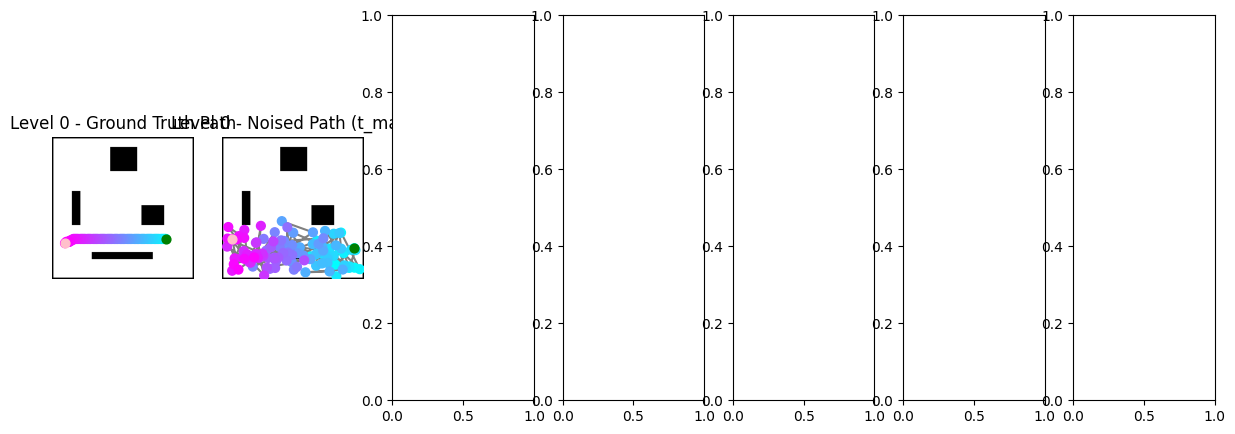

In [256]:

with torch.no_grad():
    # Sample a batch of paths for visualization
    sample_data = next(iter(val_vis_dataloader))
    # Squeeze to get rid of batch dimension. We only need one sample
    sample_map = sample_data['map'].to(device)
    sample_path = sample_data['astar_path'].to(device)
    sample_mask = sample_data['astar_mask'].to(device)
    sample_start_point = sample_data['start_point'].to(device)
    sample_end_point = sample_data['end_point'].to(device)


    generate_plan(sample_map, sample_path, sample_mask, sample_start_point, sample_end_point, unet_models, target_lengths, 0, device, num_timestep_display=5, visualize=True, guess_dist=guess_dist)


Time

In [100]:
import time 

def time_diffusion(map, path, mask, start_point, end_point, models, target_lengths, num_levels, device, num_timestep_display=5, visualize=True):

   
    # Get the map embeddings
    maps_preprocessed = preprocess_maps(map)
    map_embeddings = resnet18_feature_extractor(maps_preprocessed)
    # Flatten embeddings
    map_embeddings = map_embeddings.view(map_embeddings.size(0), -1)

    total_t = 0

    # Iterate through the levels
    for level, unet_model in enumerate(models):

        print(f"-------- Level {level} ---------")

        target_length = target_lengths[level]

        # Always resample to 128 waypoints
        reduced_path_tensor, reduced_mask_tensor = resample_path(path, mask, target_length=target_lengths[0])

        # --- Denoising Process:

        # Get initial noised path
        t_max = multi_level_diffusion_model.models[level].timesteps - 1
        t_max = 300 - 1
        t_tensor = torch.tensor([t_max], device=device)

        # Get initial noisy path for this level
        initial_noisy_path, _ = multi_level_diffusion_model.models[level].forward(reduced_path_tensor.unsqueeze(0), t_tensor, reduced_mask_tensor.unsqueeze(0), device)
        current_denoised_path = initial_noisy_path.squeeze(0).permute(0,2,1)

        conditioned_path = None
        receded_indices = None
        if level > 0:
            # Select the points closest to the start point after adding noise
            current_denoised_path, receded_indices, furthest_points, furthest_indices= select_closest_and_furthest_points(current_denoised_path, start_point, target_lengths[level], device)
            # Condition on the furthest points 
            conditioned_path = furthest_points
                                                   
        start_time = time.time()

        # Denoise each timestep at a time in reverse
        for t in reversed(range((t_max + 1))):
            # t_tensor = torch.tensor([t], device=device)
            current_denoised_path = multi_level_diffusion_model.models[level].backward(current_denoised_path, t_tensor, map_embeddings, start_point, end_point, unet_model, sparse_path=conditioned_path)
            

            # Break the loop if t reaches half of t_max and not the last level
            if (t <= (t_max//2)):
                break
            total_t+=1

        end_time = time.time()

        print(f"Level {level} Time: {end_time-start_time} T_max: {t_max} Total Time = {total_t}")
        


In [44]:
with torch.no_grad():
    # Sample a batch of paths for visualization
    sample_data = next(iter(val_vis_dataloader))
    # Squeeze to get rid of batch dimension. We only need one sample
    sample_map = sample_data['map'].to(device)
    sample_path = sample_data['astar_path'].to(device)
    sample_mask = sample_data['astar_mask'].to(device)
    sample_start_point = sample_data['start_point'].to(device)
    sample_end_point = sample_data['end_point'].to(device)

    time_diffusion(sample_map, sample_path, sample_mask, sample_start_point, sample_end_point, unet_models, target_lengths, num_levels, device, num_timestep_display=5, visualize=True)
    

NameError: name 'time_diffusion' is not defined

In [264]:
128 - 64

64

Tensorboard

In [3]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
%tensorboard --logdir=runs/diffusion_training_loss

Reusing TensorBoard on port 6006 (pid 3865), started 0:00:11 ago. (Use '!kill 3865' to kill it.)